In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import dask
import dask.array as da
import dask.dataframe as dd
from IPython.display import Markdown
import cmdstanpy
import statsmodels.api as sm

In [2]:
%%time
import polars as pl
test_series = (pl.scan_parquet('test_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 184 ms, sys: 96.8 ms, total: 281 ms
Wall time: 3.28 s


In [3]:
from pandas.api.types import is_datetime64_ns_dtype
import gc

import warnings
warnings.filterwarnings("ignore")

def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    df['series_id'] = df['series_id'].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

In [4]:
test_series = reduce_mem_usage(test_series)

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 23.71%


In [5]:
series_ids = test_series['series_id'].unique()

# Subject 1

In [79]:
test_data = test_series[test_series.series_id == series_ids[0]]

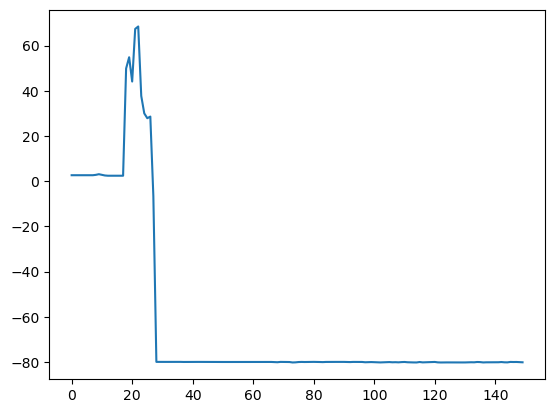

In [80]:
plt.plot(test_data.anglez)

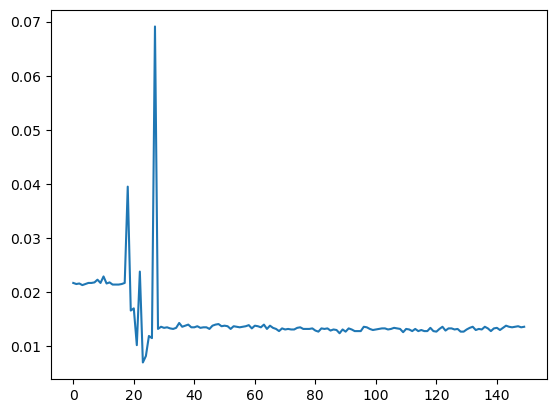

In [81]:
plt.plot(test_data.enmo)

### Stan

In [82]:
data = {"T": 150, 'y' : np.array(test_data.anglez)}

model = cmdstanpy.CmdStanModel(stan_file = 'Stan/Normal_SandSAR1.stan')

08:30:04 - cmdstanpy - INFO - compiling stan file /accounts/projects/sleepstates/Stan/Normal_SandSAR1.stan to exe file /accounts/projects/sleepstates/Stan/Normal_SandSAR1
08:30:44 - cmdstanpy - INFO - compiled model executable: /accounts/projects/sleepstates/Stan/Normal_SandSAR1


In [83]:
mle = model.optimize(data=data)

08:30:45 - cmdstanpy - INFO - Chain [1] start processing
08:30:45 - cmdstanpy - INFO - Chain [1] done processing


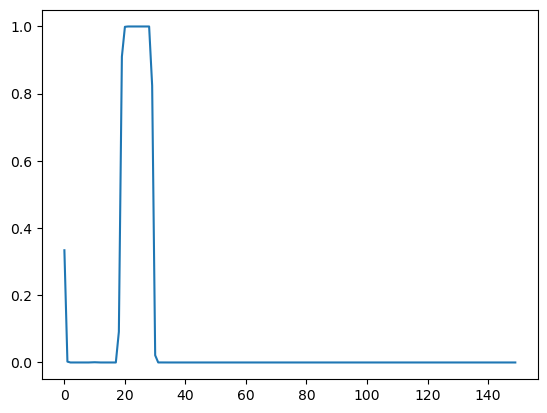

In [84]:
plt.plot(mle.stan_variable('xi')[:,0])

In [56]:
switch = sm.tsa.MarkovRegression(
    test_data.anglez[1:],
    k_regimes = 2,
    exog = test_data.anglez[:-1], 
    #switching_trend = False, 
    #switching_exog = False,
    switching_variance = True)
switch_fit = switch.fit()

In [57]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 anglez   No. Observations:                  149
Model:               MarkovRegression   Log Likelihood                -476.570
Date:                Fri, 03 Nov 2023   AIC                            969.139
Time:                        08:17:35   BIC                            993.171
Sample:                             0   HQIC                           978.903
                                - 149                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5165      0.063     56.117      0.000       3.394       3.639
x1            -0.3534      0.009    -40.356      0.000      -0.371      -0.336
sigma2         0.0478      0.016      2.991      0.003       0.016       0.079
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7578      1.806     -1.527      0.127      -6.297       0.781
x1             0.9663      0.023     41.739      0.000       0.921       1.012
sigma2        70.0873      8.727      8.031      0.000      52.983      87.191
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9327      0.058     15.998      0.000       0.818       1.047
p[1->0]        0.0138      0.010      1.389      0.165      -0.006       0.033
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

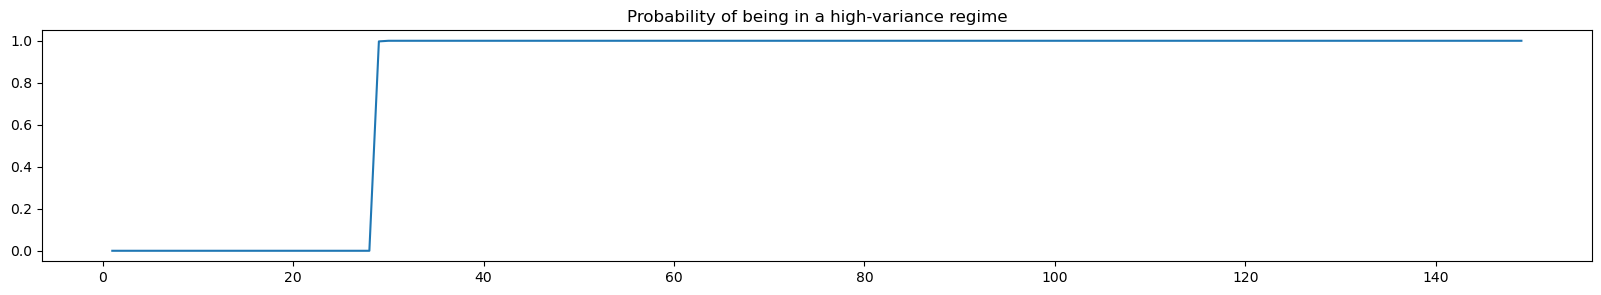

In [41]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))

### Subject 2

In [65]:
test_data = test_series[test_series.series_id == series_ids[1]]

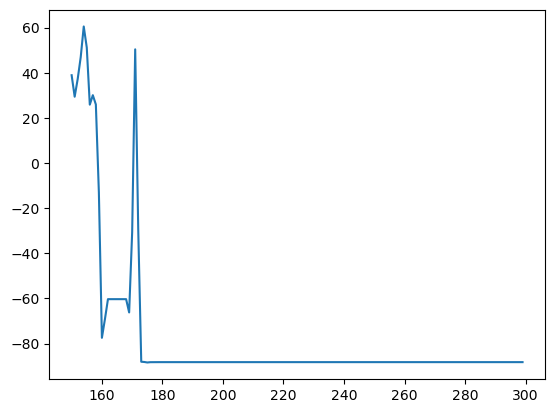

In [66]:
plt.plot(test_data.anglez)

In [67]:
data = {"T": 150, 'y' : np.array(test_data.anglez)}

model = cmdstanpy.CmdStanModel(stan_file = 'Stan/Normal_SandSAR1.stan')

In [70]:
mle = model.optimize(data=data)

08:20:45 - cmdstanpy - INFO - Chain [1] start processing
08:20:45 - cmdstanpy - INFO - Chain [1] done processing


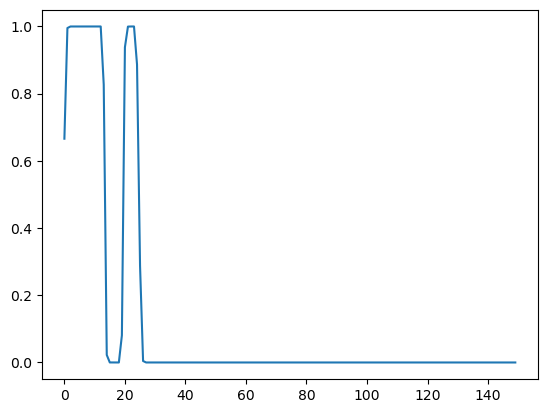

In [71]:
plt.plot(mle.stan_variable('xi')[:,0])

In [64]:
switch = sm.tsa.MarkovRegression(
    test_data.anglez[1:],
    k_regimes = 2,
    exog = test_data.anglez[:-1], 
    switching_trend = False, 
    switching_exog = False,
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 anglez   No. Observations:                  149
Model:               MarkovRegression   Log Likelihood                2340.693
Date:                Wed, 01 Nov 2023   AIC                          -4669.386
Time:                        15:59:33   BIC                          -4651.362
Sample:                             0   HQIC                         -4662.063
                                - 149                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.237e-19   8.91e-12   2.51e-08      1.000   -1.75e-11    1.75e-11
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       969.0508   2.13e-53   4.54e+55      0.000     969.051     969.051
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7206   6.06e-11  -1.61e+11      0.000      -9.721      -9.721
x1             0.8898   6.87e-13    1.3e+12      0.000       0.890       0.890
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9921   2.27e-20   4.36e+19      0.000       0.992       0.992
p[1->0]        0.0420   2.26e-19   1.86e+17      0.000       0.042       0.042
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 9.42e+101. Standard errors may be unstable.
"""

<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

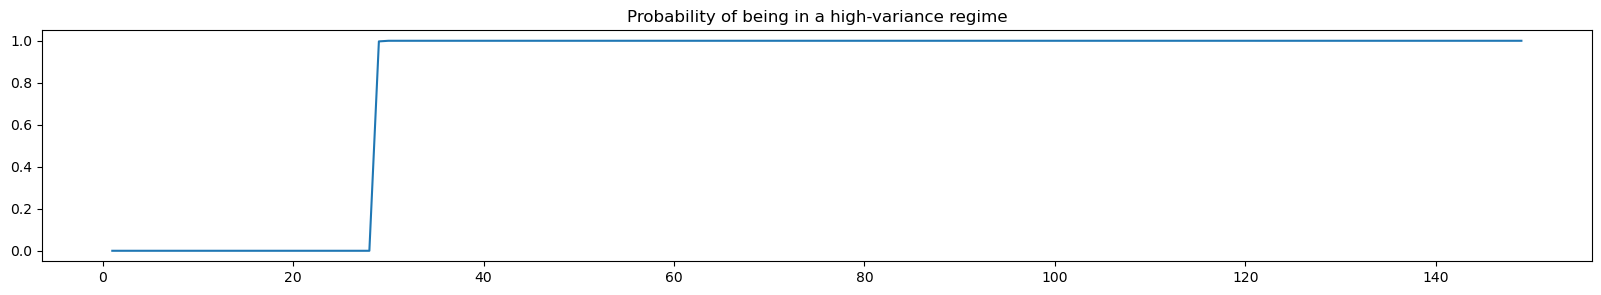

In [61]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))

### Subject 3

In [85]:
test_data = test_series[test_series.series_id == series_ids[2]]

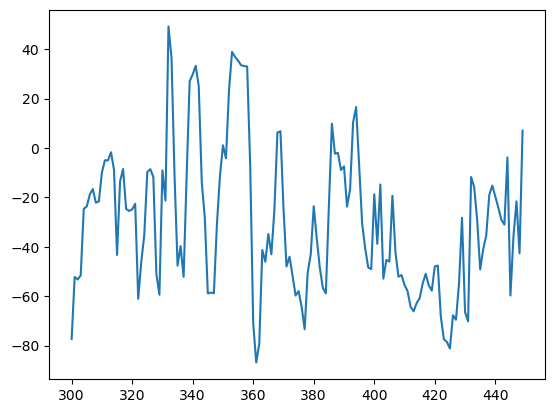

In [86]:
plt.plot(test_data.anglez)

In [87]:
data = {"T": 150, 'y' : np.array(test_data.anglez)}

model = cmdstanpy.CmdStanModel(stan_file = 'Stan/Normal_SandSAR1.stan')

In [88]:
mle = model.optimize(data=data)

08:33:04 - cmdstanpy - INFO - Chain [1] start processing
08:33:04 - cmdstanpy - INFO - Chain [1] done processing


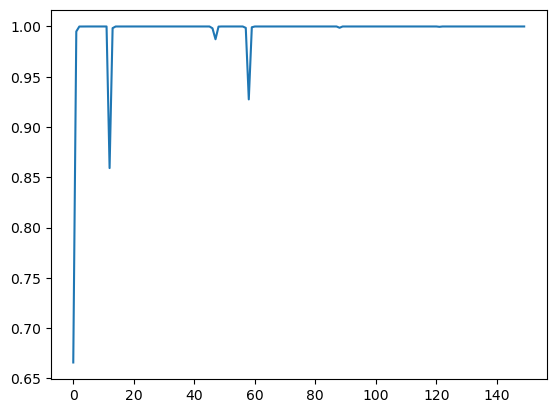

In [89]:
plt.plot(mle.stan_variable('xi')[:,0])

In [69]:
switch = sm.tsa.MarkovRegression(
    test_data.anglez[1:],
    k_regimes = 2,
    exog = test_data.anglez[:-1], 
    switching_trend = False, 
    switching_exog = False,
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [70]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 anglez   No. Observations:                  149
Model:               MarkovRegression   Log Likelihood                -644.727
Date:                Wed, 01 Nov 2023   AIC                           1301.454
Time:                        16:00:46   BIC                           1319.478
Sample:                             0   HQIC                          1308.777
                                - 149                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        22.2634     10.458      2.129      0.033       1.765      42.762
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       618.0041    102.070      6.055      0.000     417.951     818.058
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6827      1.203     -1.399      0.162      -4.040       0.675
x1             0.9648      0.032     30.030      0.000       0.902       1.028
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6470      0.109      5.948      0.000       0.434       0.860
p[1->0]        0.1679      0.074      2.258      0.024       0.022       0.314
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

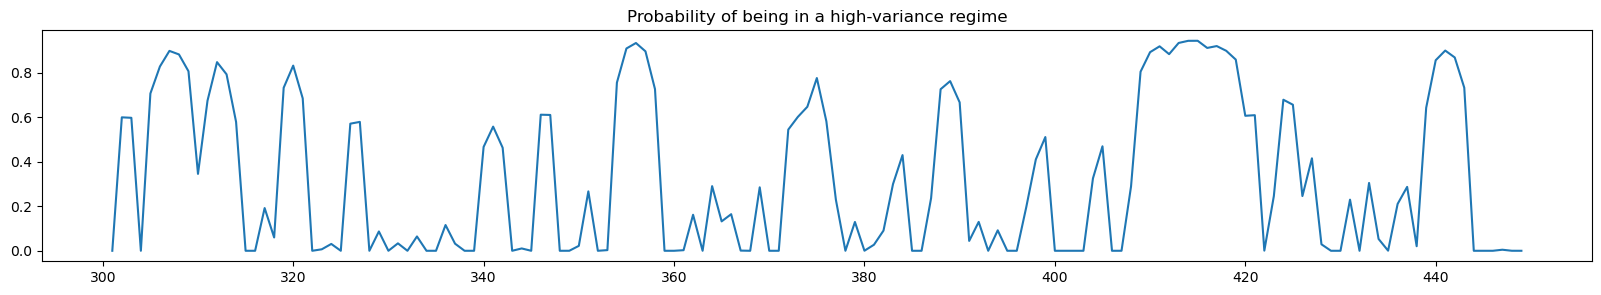

In [71]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))